### **Indexing and Retrieving with Qwen2 model and Elasticsearch**

1. Importing Required Libraries

    - Loads essential libraries for handling text (`pandas`, `numpy`), deep learning (`torch`, `transformers`), and Elasticsearch interaction.
    - Includes `PIL` for image processing and `hashlib` for unique document ID generation.

In [2]:
import torch
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import hashlib
from tqdm import tqdm
import os
import base64
from PIL import Image
import io
from dataProcessor import process_metadata, clean_text, correct_misinterpreted_characters, pew_metadata_path, statista_metadata_path, llava_description_path
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
import torch
import torch.nn.functional as F
from torch import Tensor

2. Data Preprocessing

    - Reads metadata from multiple datasets (`pew`, `statista`, `llava_description`).
    - Cleans and corrects text fields (`title`, `caption`, `llava_description`).
    - Combines all sources into a single dataframe.

In [2]:
#  get the combined dataframe
combined_df = process_metadata(pew_metadata_path, statista_metadata_path, llava_description_path)

# Apply text cleaning and correction functions
combined_df['title'] = combined_df['title'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['caption'] = combined_df['caption'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['llava_description'] = combined_df['llava_description'].apply(clean_text).apply(correct_misinterpreted_characters)

combined_df.shape

(29354, 5)

3. Encoding Images to Base64

    - Defines `image_to_base64()` function to convert images into Base64 encoding for storage in Elasticsearch.

In [3]:
# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        # Read the image file
        img_bytes = img_file.read()
        # Encode image bytes to Base64
        base64_img = base64.b64encode(img_bytes).decode("utf-8")
        return base64_img

4. Loading Qwen2 Model with Quantization

    - Uses `Alibaba-NLP/gte-Qwen2-7B-instruct` for embedding generation.
    - Enables `BitsAndBytesConfig` for 4-bit quantization to optimize inference.
    - Loads tokenizer and model with `trust_remote_code=True`, automatically assigning the device (`CUDA` or `CPU`).

In [4]:
# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load the tokenizer and quantized model
tokenizer = AutoTokenizer.from_pretrained('Alibaba-NLP/gte-Qwen2-7B-instruct', trust_remote_code=True)
model = AutoModel.from_pretrained(
    'Alibaba-NLP/gte-Qwen2-7B-instruct', trust_remote_code=True,
    quantization_config=quantization_config,
    device_map="auto"
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


5. Connecting to Elasticsearch

    - Initializes an Elasticsearch instance and sets the index name (`"documents"`).
    - Ensures connection to the local Elasticsearch server.

In [5]:
# Correctly formatted URL for a local Elasticsearch instance
es = Elasticsearch(["http://localhost:9200"])

# define the index name
index_name = "documents"

6. Moving Model to Correct Device
- Checks if CUDA is available and moves the model to GPU for better performance.
- Prints the device on which the model is loaded.

In [6]:
# Ensure inputs are moved to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move the model to the appropriate device if needed
print(f"Model is on device: {next(model.parameters()).device}")

# Define the maximum length for the input text
max_length = 1250

Using device: cuda
Model is on device: cuda:0


7. Defining Last Token Pooling

    - Implements a function to extract meaningful vector representations from the last hidden states.
    - Handles different padding styles (left or right padding).

8. Formatting Query Instructions for Embeddings

    - Defines `get_detailed_instruct()` to structure the query format for better retrieval accuracy.

9. Generating Text Embeddings

    - Uses `embed_texts()` to generate normalized embeddings for text inputs.
    - Processes text with the Qwen2 model and returns a flattened embedding vector.

In [7]:
# Function to perform last token pooling on hidden states based on the attention mask.
# It handles cases with left or right padding.
def last_token_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]
    
    
# Function to format a detailed instruction string from a task description and query.
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

# Function to embed texts
def embed_texts(texts):
    input_token = tokenizer(texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
    input_token = {k: v.to(device) for k, v in input_token.items()}
    with torch.no_grad():  # Ensure no gradients are calculated
        outputs = model(**input_token)
        embeddings = last_token_pool(outputs.last_hidden_state, input_token['attention_mask'])
        embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings.detach().cpu().numpy().flatten().tolist()

10. Indexing Documents in Elasticsearch

    - Iterates over the dataset to:
    - Combine `title` and `caption` for embedding generation.
    - Compute a unique hash ID for each document.
    - Store the generated embeddings (`gte_embedding`) in Elasticsearch using the unique document ID.

11. Clearing CUDA Cache
    - Frees GPU memory after processing each document to optimize performance.

In [8]:
# Indexing the documents into embeddings using Elasticsearch with its unique ID, ensuring no duplicates are created.
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    # Concatenate title and caption with a space or some delimiter
    combined_text = f"{row['title']}. {row['caption']}"
    
    # Generate embedding for the combined text
    embedding = embed_texts(combined_text)

    # Generate a unique ID for the document using a hash of the title and caption
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # update the document in the index with the gte embedding
    es.update(index=index_name, id=unique_id, body={
        "doc": {
            "gte_embedding": embedding
        }
    })
    
    # Clear CUDA cache
    torch.cuda.empty_cache()

    # Optional: Clear variables if no longer needed
    del combined_text, embedding, unique_id

100%|██████████| 29354/29354 [2:27:28<00:00,  3.32it/s]  


12. Counting Indexed Documents
    
    - Retrieves and prints the total number of indexed documents in Elasticsearch.

In [9]:
doc_count = es.count(index=index_name)['count']
print(f"Number of documents in the index: {doc_count}")

Number of documents in the index: 29348


13. Ranking Topics Based on Similarity Scores

    - Reads queries from `classified_questions.csv`.
    - Embeds each topic query using the Qwen2 model.
    - Executes an Elasticsearch similarity search and ranks topics based on cosine similarity scores.
    - Saves the top 12,061 relevant topics in a CSV file (`TopRelevant_topics.csv`).

In [20]:
# Define the task description
task = 'Given a web search query, retrieve relevant passages that answer the query'

# Assuming initialization and index creation as before
topics_df = pd.read_csv('../dataset/classified_questions.csv')

# Dictionary to hold total similarity scores for each topic
topic_similarity_scores = {}

for _, row in tqdm(topics_df.iterrows(), total=topics_df.shape[0], desc="Processing topics"):
    question = row['Question']
    query = get_detailed_instruct(task, question)
    query_embedding = embed_texts(query)
    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, 'gte_embedding') + 1.0",
                "params": {"query_vector": query_embedding}
            }
        }
    }
    
    response = es.search(index=index_name, body={
        "size": 30,  # You might want to adjust this size based on your needs
        "query": script_query,
        "_source": {"includes": ["title", "content"]}  # Include the image data in the response
    })

    # Sum up the scores of all hits for this topic
    total_score = sum(hit['_score'] for hit in response['hits']['hits'])
    topic_similarity_scores[question] = total_score

    # Rank topics by their total similarity score
sorted_topics = sorted(topic_similarity_scores.items(), key=lambda x: x[1], reverse=True)

Processing topics: 100%|██████████| 12061/12061 [53:41<00:00,  3.74it/s] 


In [21]:
# Output the top 10 relevant topics
print("Top 10 Relevant Topics Based on Similarity Score:")
for i, (topic, score) in enumerate(sorted_topics[:12061], 1):
    print(f"{i}. Topic: {topic}, Total Similarity Score: {score}")


Top 10 Relevant Topics Based on Similarity Score:
1. Topic: Is a 5.7 infant mortality rate per 1,000 live births in Saudi Arabia a, Total Similarity Score: 49.93076719999999
2. Topic: Is a 15.7 infant mortality rate per 1,000 live births in Trinidad and Tob, Total Similarity Score: 49.531235599999995
3. Topic: Does the travel and tourism industry have a significant impact on Europe's GDP?, Total Similarity Score: 49.4815166
4. Topic: Has the COVID-19 pandemic increased online shopping among consumers in the Philippines?, Total Similarity Score: 49.265723600000015
5. Topic: Is a 12.2 infant mortality rate per 1,000 live births in Mexico unaccept, Total Similarity Score: 49.033040400000004
6. Topic: Does the COVID-19 pandemic lead to increased grocery sales?, Total Similarity Score: 48.99327949999999
7. Topic: Is a 2.9% youth unemployment rate in Uganda considered low?, Total Similarity Score: 48.978201699999985
8. Topic: Are natural gas prices for households in Italy too high?, Total Si

In [22]:
# Create a DataFrame with the top relevant topics and their similarity scores
topics_df = pd.DataFrame(sorted_topics[:12061], columns=['Topic', 'Similarity Score'])
# Specify the full path for saving the CSV file
csv_path = '../dataset/TopRelevant_topics.csv'
# Save the DataFrame to the specified CSV file path
topics_df.to_csv(csv_path, index=False)

print("Top relevant topics saved to TopRelevant_topics.csv")

Top relevant topics saved to TopRelevant_topics.csv


14. Retrieving Context for a Random Topic**
    - Selects a random topic from `TopRelevant_topics.csv`.
    - Generates an embedding for the query.
    - Executes an Elasticsearch search to retrieve top relevant passages.

15. Extracting and Displaying Relevant Documents
    - Retrieves and prints the top 3 search results with their `"title"`, `"content"`, and `"score"`.
    - Decodes Base64-encoded images and displays the associated images.

***Retriving the top context from a random topic***

In [10]:
# Select a random topic
import random   
topics_df = pd.read_csv('../dataset/TopRelevant_topics.csv')   
question = random.choice(topics_df['Topic'].to_list())
#question= 'Are gas prices too high?'

# Define the task description
task = 'Given a web search query, retrieve relevant passages that answer the query'

# Generate the detailed instruction string
query = get_detailed_instruct(task, question)
query_embedding = embed_texts(query)

# Define the script query for Elasticsearch
query

'Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery: Should online marketplaces like eBay be subject to stricter regulations?'

Top 3 relevant documents for the topic 'Should online marketplaces like eBay be subject to stricter regulations?':

1. Title: Annual net revenue of eBay from 2013 to 2019                                                     (in million U.S. dollars)
   Content: In the most recently reported fiscal year, eBay's annual net revenue amounted to more than 10.8 billion U.S. dollars, only a slight increase from 10.7 billion U.S. dollars in the preceding year. The majority of eBay’s revenues are generated via marketplace transaction fees. eBay ...further information Founded in 1995, eBay is one of the oldest online shopping destinations with operations localized in over 30 countries. eBay.com is a global platform, allowing people and businesses to buy and sell a large variety of goods and services worldwide. In addition to auction style listings, eBay also expanded to include fixed-price "Buy it Now...shopping, in addition to localized classifieds listings. As of the fourth quarter of 2019, eBa

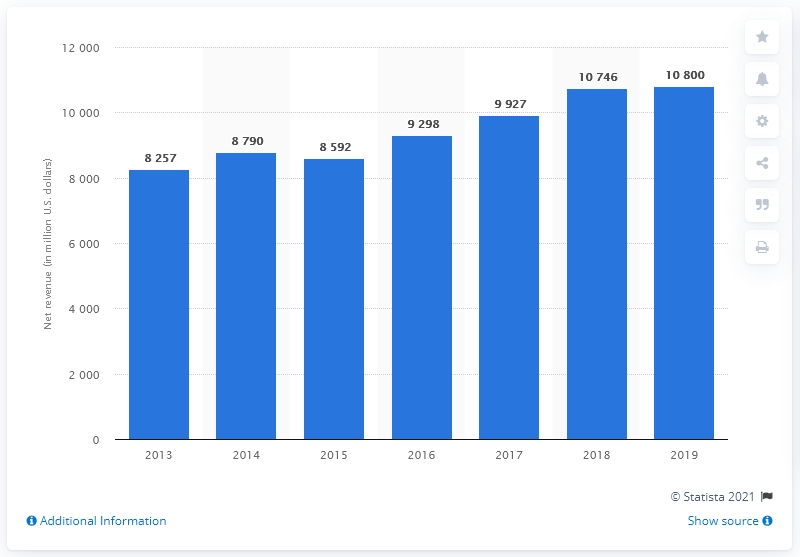

2. Title: eBay's gross merchandise volume (GMV) from 2007 to 2019                                                     (in billion U.S. dollars)
   Content: This statistic gives information on eBay's total gross merchandise volume from 2007 to 2019. In the most recently reported fiscal year, the auction site's gross merchandising volume (GMV) amounted 90.21 billion U.S. dollars, down from 94.58 billion U.S. dollars in the preceding year. The majority of GMV was generated via the company's Marketplace segment.
   Score: 1.4168591



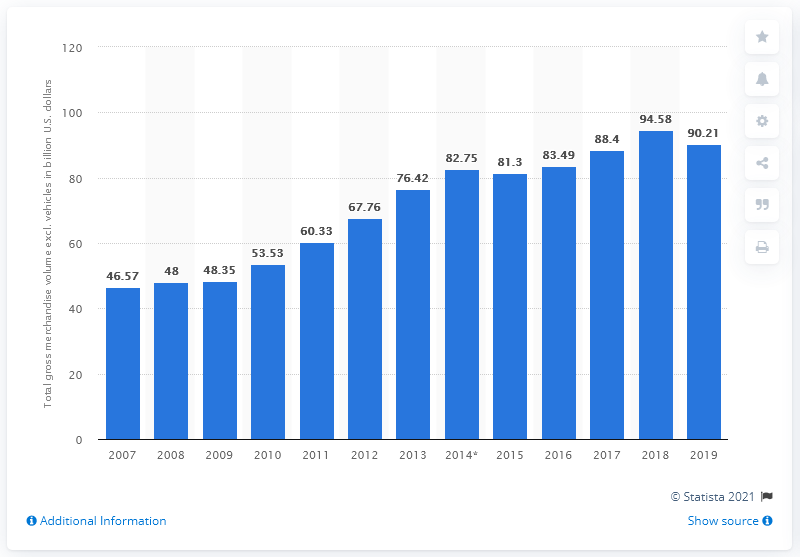

3. Title: eBay's revenue from 1st quarter 2014 to 3rd quarter 2020                                                     (in million U.S. dollars)
   Content: eBay's revenue in the second quarter of 2020 amounted to over 2.6 billion U.S. dollars. This represents a 25 percent year-on-year increase. The majority of revenue is generated through transactions, which accounted for 2.36 billion U.S. dollars in the most recent quarter. MS&O revenues consists of marketplace, StubHub and classifieds, which amounted to 251 million U.S. dollars during the most recently measured period.
   Score: 1.4105788



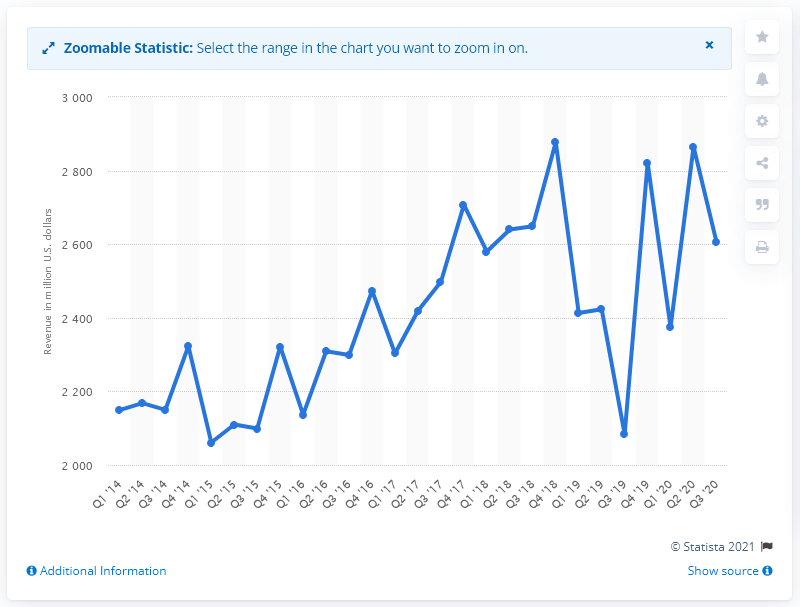

: 

In [11]:
# Elasticsearch query to find relevant documents based on cosine similarity
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'gte_embedding')+ 1.00",
            "params": {"query_vector": query_embedding}
        }
    }
}
    
# Execute the search query
response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]  # Include image data if available
})

# Extract and print the top 3 relevant documents
print(f"Top 3 relevant documents for the topic '{question}':\n")

for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']}\n   Content: {doc['content']}\n   Score: {hit['_score']}\n")

    # Decode Base64-encoded image data
    image_bytes = base64.b64decode(doc['image_data'])
    
    # Open the image from bytes
    image = Image.open(io.BytesIO(image_bytes))
    
    # Display the image
    image.show()

16. Final Cleanup
    - Clears the CUDA cache to free GPU memory.

In [3]:
# Clear CUDA cache
torch.cuda.empty_cache()